# New york taxi fare prediction

By Alexis Moraga & Felipe Perez

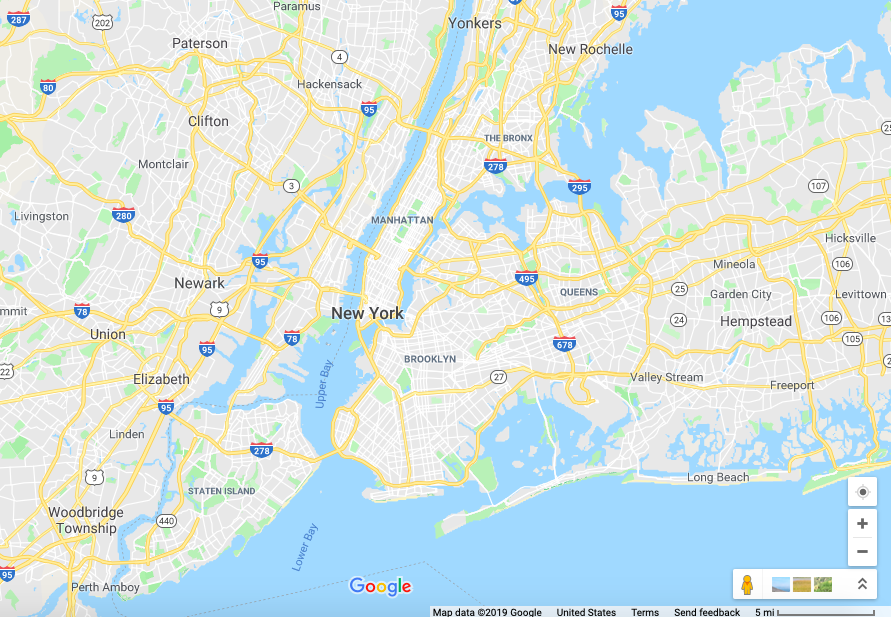

In [1]:
from IPython.display import Image
Image("../input/nypict/nypic.png")

## Introduction

In this notebook we work the problem of predicting the taxi fare in New York City, problem posed in Kaggle (see [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)). Our approach can be outlined as:

1. Data cleansing
2. Feature engineering
3. Univariate and bivariate analysis
4. Fit of a linear regression model
5. Fit of a random forest regressor
6. Prediction and submission of the results.
7. Final remarks

In each section, we will go into the details of the analysis. Most of our work focuses on the feature engineering so that we can fit the models without having to work very hard on the optimization of the hyperparameters.

The modules we will use throughout this notebook:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Loading the data

We now read the training data into a dataframe. We read the first 2 000 000 lines as training and the next 10 000 lines as test data.

In [3]:
df = pd.read_csv("../input/new-york-city-taxi-fare-prediction/train.csv", nrows = 2000000)
df_test = pd.read_csv("../input/new-york-city-taxi-fare-prediction/train.csv", skiprows = 2000000, nrows = 10000)
df.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


We change the names of the columns

In [4]:
df.columns = ['key','fare','time','pickup_lon','pickup_lat','dropoff_lon','dropoff_lat','passn']
df_test.columns = ['key','fare','time','pickup_lon','pickup_lat','dropoff_lon','dropoff_lat','passn']

Let's take a quick look at the mean fare over the training data:

In [5]:
df['fare'].mean()

11.347788759996057

This is our first piece of information about the distribution of the data we will analyze. We will study in more depth the distribution of the `fare` response. 

## Measuring distances

As we can see in the bried description of the data given by `df.head()`, we count with the pick up and drop off locations, in terms of latitude and longitude. As our intuition dictates, the `fare` should be somehow correlated with the total distance traveled by the taxi. As we do not have the information of the path traveled by the taxi, we need to estimate such distance. Now, longitude and latitude are essentially reparametrizations of the polar and azimuthal angles for the spherical coordinates description of the Earth. This means that in order to get from point `A` to point `B`, we need to travel through the surface of the Earth. More concretely, we need to take into account the curvature of the Earth. This can be easily done by means of trigonometric functions, but for simplicity, we decided to ingnore the effects of curvature and treat the longitude/latitude coordinates as points in a plane. In order to estimate the distance traveled by the taxi, we chose to use the $L^1$ distance, as we know a priori that the streets of New York City are closely approximable by a grid. We construct an $L^1$ distance function:

In [6]:
def dist(x,y,p = 1):
    [x1,x2] = x
    [y1,y2] = y
    return np.linalg.norm((x1-y1,x2-y2),ord = p ,axis = 0)

We now add the distance between the pick up and the drop off locations as a feature:

In [7]:
df['dist'] = pd.Series(dist( (df['pickup_lon'],df['pickup_lat']),(df['dropoff_lon'],df['dropoff_lat'])))
df_test['dist'] = pd.Series(dist( (df_test['pickup_lon'],df_test['pickup_lat']),(df_test['dropoff_lon'],df_test['dropoff_lat'])))

This distance does not have a unit, as it is essentially measuring distance between angles.

## Dealing with time

We now parse the time data from our dataset:

In [8]:
df['time'] = pd.to_datetime(df['time'],infer_datetime_format=True)
df_test['time'] = pd.to_datetime(df_test['time'],infer_datetime_format=True)

Let's have a look at the new format:

In [9]:
df.head()

,key,fare,time,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passn,dist
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.011742
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.107481
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.019212
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.029386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.027194


We will create new features corresponding to the year, day and hour:

In [10]:
df['year'] = df['time'].dt.year
df['day'] = df['time'].dt.weekday
df['hour'] = df['time'].dt.hour

df_test['year'] = df_test['time'].dt.year
df_test['day'] = df_test['time'].dt.weekday
df_test['hour'] = df_test['time'].dt.hour

## Data cleansing and feature engineering 

We proceed now to clean the training data. Let's start by checking the presence of `nan` entries in the dataframe:

In [11]:
np.sum(df[df.columns[0:8]].isna(),axis = 0)

key             0
fare            0
time            0
pickup_lon      0
pickup_lat      0
dropoff_lon    14
dropoff_lat    14
passn           0
dtype: int64

A quick Google search reveals that most of NYC fits in $(-74,-72)\times(40,42)$ in our coordinate system, so we drop anything beyond that. In view of this, we also drop any point for which the pick up and drop off location are further than `dist((-74,40),(-72,42)) = 4`. We also drop all points for which the distance traveled is zero, as this would not constitute a valid trip for a positive fare. Finally, we drop the points for which the fare is zero, as this would not constitute a valid trip either.

In [12]:
mask0 = ( (df['pickup_lon'] > -74) & (df['pickup_lat'] > 40) & (df['dropoff_lon'] < -72) & (df['dropoff_lat'] < 42)  
& (df['dist'] < 2) & (df['dist'] > 0) & (df['fare'] > 0)
        )

In [13]:
df = df[mask0]

We check again the mean of `fare` to see if it changed too much with respect to the first time we computed it:

In [14]:
df['fare'].mean()

11.305029592083287

We can see that it has not changed drastically.

## Exploratory analysis: univariate analysis

1. We perform now a simple exploratory analysis of the features. Let's start by looking at the distribution of the `fare` feature:

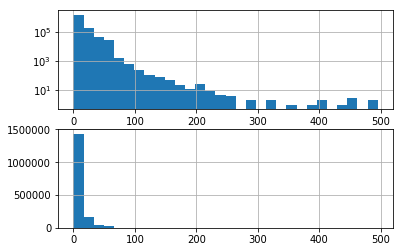

In [15]:
plt.subplot(2,1,1)
df['fare'].hist(bins = 30, log=True)
plt.subplot(2,1,2)
df['fare'].hist(bins = 30)
plt.show()

Note we plotted the histogram in regular and logarithmic scale. We can see that the distribution is highly concentrated near $0$. The range that the feature `fare` takes is given by:

In [16]:
df['fare'].min(axis = 0), df['fare'].max(axis = 0)

(0.01, 495.0)

Let's check how much of the distribution is beyond $100$ USD:

In [17]:
str(100*(np.sum(df['fare'] > 100)/len(df))) + "%"

'0.0310930242412198%'

We can compute the $99$th quintile:

In [18]:
np.percentile(df['fare'],99)

54.1

Thus, when we train the model, we can restrict `fare` to this range.

In [19]:
df = df[df['fare'] < 55]

We perform a similar analysis to the `dist` feature. Its range is given by:

In [20]:
df['dist'].min(axis = 0) , df['dist'].max(axis = 0) 

(9.999999903698154e-07, 1.9813079833984304)

We plot now the histogram to inspect the distribution of the feature:

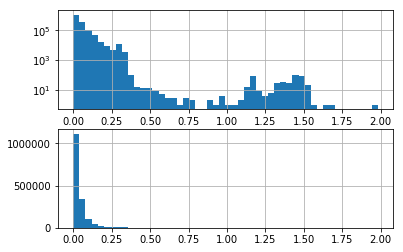

In [21]:
plt.subplot(2,1,1)
df['dist'].hist(bins = 50 , log=True)
plt.subplot(2,1,2)
df['dist'].hist(bins = 50)
plt.show()

We can see again that the distribution is concentrated around zero but also has some peaks near $1.25$. We compute the $99$th percentile for `dist`:

In [22]:
print("{0:2.2f} USD".format(np.percentile(df['dist'],99)))

0.28 USD


We restrict then to this range for `dist`:

In [23]:
df = df[df['dist'] < 0.28]

We can check what proportion of the original dataframe have we kept up to this point:

In [24]:
print("{0:2.2f}%".format(100*(len(df)/2000000)))

82.15%


## Bivariate analysis

We perform a quick exploratory bivariate analysis, mostly to detect correlations between the features. Here some common sense helps us get some intuition about what could be happening. The first remark is that we expect the distance of the trip to be correlated to the fare of it, as that is how normally taximeters work. We also expect the fare to have almost no correlation with the number of passangers, as one of the characteristics of the taxi service is the independence of the fare with respect to the number of passangers. We can check these two correlations:

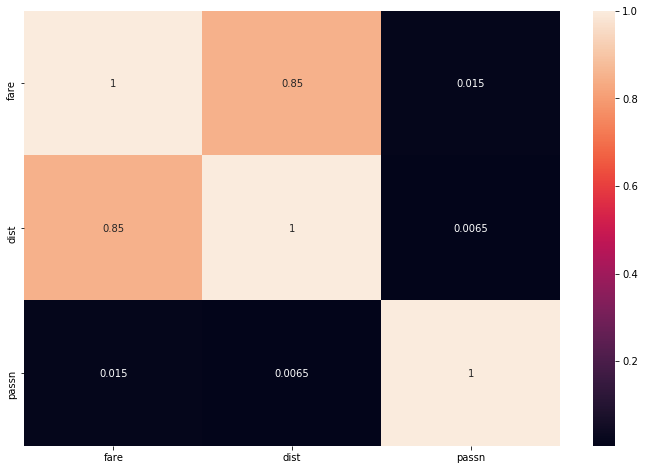

In [25]:
plt.figure(figsize=(12, 8))

corr = df[['fare','dist','passn']].corr()
sns.heatmap(corr,annot = True)

At first glance it seems that there is indeed a high correlation between `fare` and `dist` and an almost null correlation between `fare` and `passn`. We now plot `fare` against `dist`. For reasons of runtime and so that the plot is not too crowded with points, we take the first `10 000` points of the dataframe:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1008x1008 with 0 Axes>

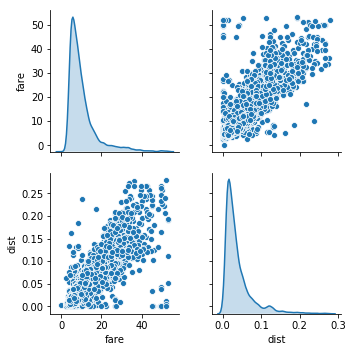

In [26]:
plt.figure(figsize=(14, 14))
sns.pairplot(df[['fare','dist']].loc[0:10000], diag_kind='kde');

Here we can clearly see the linear trend on `fare` with respect to `dist`. We proceed now to analyze the relationship between the fare of the trip and the time at which it was done. For this, we will first study how the mean fare changed over the years. The range of years in which the data was measured is:

In [27]:
np.min(df['time'].dt.year) , np.max(df['time'].dt.year)

(2009, 2015)

Now we compute and plot the yearly average of `fare`:

2009: 9.39
2010: 9.49
2011: 9.69
2012: 10.32
2013: 11.50
2014: 11.70
2015: 11.69


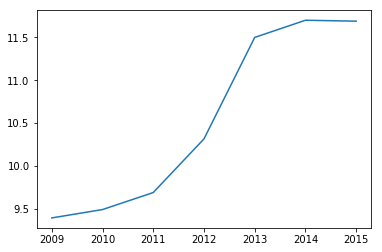

In [28]:
yearly_mean = []
for i in range(2009,2016):
    a = df[df['time'].dt.year == i]['fare'].mean()
    yearly_mean.append(a)
    print("{0}: {1:1.2f}".format(i,a))
plt.plot(range(2009,2016),yearly_mean)

We can see an upward trend in the fare as the years go by. If we graph the boxplots for the fare for each year, we can observe that the data becomes more variable, while the median does not fluctuate as much:

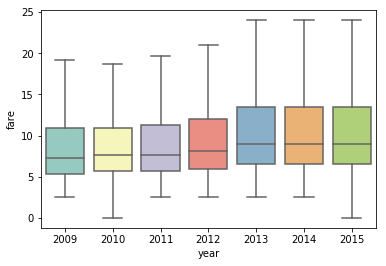

In [29]:
sns.boxplot(x="year", y="fare",data=df, palette="Set3", showfliers=False)

We perform a similar analysis for each day of the week:

Monday: 10.30
Tuesday: 10.31
Wednesday: 10.42
Thursday: 10.58
Friday: 10.52
Saturday: 10.25
Sunday: 10.65


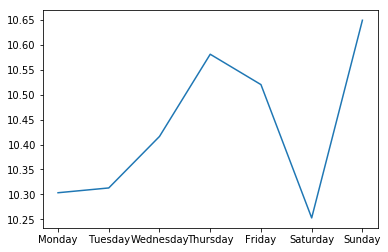

In [30]:
daily_mean = []
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    a = df[df['time'].dt.weekday == i]['fare'].mean()
    daily_mean.append(a)
    print("{0}: {1:1.2f}".format(days[i],a))
plt.plot(days,daily_mean)

The corresponding graph of botplox is then:

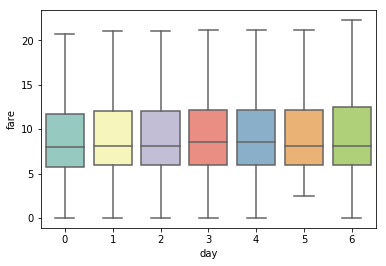

In [31]:
sns.boxplot(x="day", y="fare",data=df, palette="Set3", showfliers=False)

Finally, we explore the effect of the time of the day on the fare:

0: 11.12
1: 10.97
2: 11.08
3: 11.44
4: 12.33
5: 12.23
6: 10.25
7: 9.84
8: 10.13
9: 10.29
10: 10.21
11: 10.36
12: 10.28
13: 10.39
14: 10.50
15: 10.49
16: 10.42
17: 10.37
18: 10.13
19: 9.91
20: 10.08
21: 10.33
22: 10.66
23: 11.01


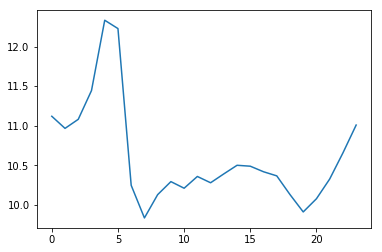

In [32]:
hourly_mean = []
for i in range(24):
    a = df[df['time'].dt.hour == i]['fare'].mean()
    hourly_mean.append(a)
    print("{0}: {1:1.2f}".format(i,a))
plt.plot(range(24),hourly_mean)

We can observe that the fare increases overnight, peaking at around 4-5 am. This might be due to the effect of traffic early in the morning as well as longer trips from/to home/work and vice versa.

## First model: linear regression

The feature analysis from the previous sections has given us enough clues to think that there might be a linear relationship between the feature `dist` and the response `fare`. Based on this, we proceed to implement our first model: a simple linear regression. We use the implementation of `sklearn`:

In [33]:
from sklearn.linear_model import LinearRegression

We define the model to be fitted: we use a linear regression with default hyperparameters:

In [34]:
reg = LinearRegression()

We define now the training data

In [35]:
X_train = df['dist'].values.reshape(-1,1)
y_train = df['fare'].values.reshape(-1,1)

With this we can fit the model:

In [36]:
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

We test the quality of the fit by looking at the root mean-squared error:

In [37]:
from sklearn.metrics import median_absolute_error , mean_squared_error
np.sqrt(mean_squared_error(y_train, reg.predict(X_train)) )

3.836235584171365

We can see that the model fits the data fairly well. It is worth pointing out that this was done *after* cleaning the data from outliers. We compute the same metric on a test set:

In [38]:
X_test = df_test['dist'].values.reshape(-1,1)
y_test = df_test['fare'].values.reshape(-1,1)
np.sqrt(mean_squared_error(y_test,reg.predict(X_test)))

860.058828463538

This number may seem high, but as pointed out above, the dataset from which the test points were extracted has a very high number of outliers, and the mean squared error is very sensitive to them. We can see for instance that a considerable number of points have degenerate pick up and drop off locations, and hence degenerate distance. This skews the mean squared error considerably.

In [39]:
df_test[df_test['pickup_lon'] == 0]

,key,fare,time,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passn,dist,year,day,hour
18,2013-09-12 16:28:10.0000001,15.5,2013-09-12 16:28:10,0.0,0.0,0.000000,0.000000,1,0.000000,2013,3,16
25,2011-01-03 08:41:00.00000089,5.7,2011-01-03 08:41:00,0.0,0.0,0.000000,0.000000,1,0.000000,2011,0,8
59,2011-09-02 14:24:00.00000077,24.5,2011-09-02 14:24:00,0.0,0.0,0.000000,0.000000,1,0.000000,2011,4,14
75,2014-08-01 16:43:16.0000001,16.5,2014-08-01 16:43:16,0.0,0.0,0.000000,0.000000,1,0.000000,2014,4,16
185,2014-04-03 09:36:17.0000002,13.0,2014-04-03 09:36:17,0.0,0.0,0.000000,0.000000,1,0.000000,2014,3,9
287,2014-11-17 12:42:10.0000005,34.0,2014-11-17 12:42:10,0.0,0.0,0.000000,0.000000,1,0.000000,2014,0,12
409,2012-04-06 08:49:59.0000004,4.5,2012-04-06 08:49:59,0.0,0.0,0.000000,0.000000,1,0.000000,2012,4,8
467,2012-12-14 19:34:19.0000002,7.5,2012-12-14 19:34:19,0.0,0.0,0.000000,0.000000,1,0.000000,2012,4,19
626,2009-09-26 06:16:00.00000035,7.3,2009-09-26 06:16:00,0.0,0.0,0.000000,0.000000,1,0.000000,2009,5,6
690,2011-01-28 10:48:00.00000055,11.7,2011-01-28 10:48:00,0.0,0.0,0.000000,0.000000,5,0.000000,2011,4,10


A more realistic test dataset would have similar characteristics to the cleaned training dataset, but we skip this analysis. With this approach, we obtained in the submitted version of the competition a root mean squared error of around 6.

It would be natural to incorporate more features to the linear model, such as the year/day/hour features, but given that the relationships between the `fare` response and these new features might not be linear, we decided to incorporate these features in a different model.

## Random forest

In the previous sections we studied some statistical properties of some of the features we deemed important according to the problem we are dealing with, as well as the relationship between them. This lead us to implement a linear model, with the main feature being `dist`. It turns out that some of the time features might play a role in the prediction of the response, so we use a Random Forest model to incorporate this features into our analysis. One of the advantages of this model is that it provides some insight on the importance of each feature for an accurate prediction of the response, which can be used to test our hypothesis.

We import the Random Forest Regressor module, as well as the Grid Search CV. With the latter we find optimal hyperparameters for the random fores model.

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

The space of parameters over we search for the optimum is:

In [41]:
param = {'min_samples_leaf':[20,25,30],'max_depth':[20,30,40]}

We build our regressor and grid:

In [42]:
rf = RandomForestRegressor(n_estimators=25)
grid = GridSearchCV(rf,param,cv=3,n_jobs=-1)

For this model, we incorporate the time features:

In [43]:
X_train = df[['pickup_lon','pickup_lat','dropoff_lon','dropoff_lat','passn','dist','year','hour']]
y_train = df['fare']

We proceed to perform the grid search and then fit the optimal model to `reg`. We use a smaller sample of `X_train,y_train` for time purposes:

In [44]:
grid.fit(X_train.loc[0:200000],y_train.loc[0:200000])
print(grid.best_params_,grid.best_score_)
reg = grid.best_estimator_

{'max_depth': 30, 'min_samples_leaf': 20} 0.8208807972868908


We can see what is the optimal configuration. Now we can extract the importance of features provided by the random forest:

In [45]:
importances = reg.feature_importances_
idx = np.argsort(importances)[::-1][0:7]
feature_names = X_train.columns.values
print(X_train.columns[idx])

Index(['dist', 'year', 'dropoff_lat', 'dropoff_lon', 'pickup_lon',
       'pickup_lat', 'hour'],
      dtype='object')


We can now plot the importance of features

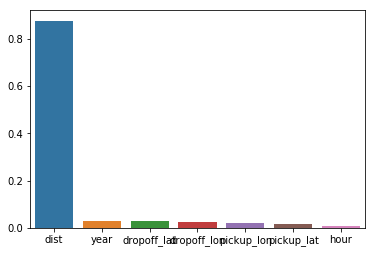

In [46]:
sns.barplot(x=feature_names[idx], y=importances[idx])

As we can see, the feature `dist` is overwhelmingly more dominant over the rest of the features when it comes to the prediction of `fare`. This gives our hypothesis from the previous sections a firmer background. 

## Submission of the results

In this section we give the proper format to the predictions to submit them to the platform of Kaggle. We first load the submission test dataset:

In [47]:
df_sub = pd.read_csv("../input/new-york-city-taxi-fare-prediction/test.csv")

Now we give it the same format as the training data. We start by adding the `dist` column and renaming the columns.

In [48]:
df_sub['dist'] = dist((df_sub['pickup_longitude'],df_sub['pickup_latitude']),(df_sub['dropoff_longitude'],df_sub['dropoff_latitude']))
df_sub.columns = ['key','time','pickup_lon','pickup_lat','dropoff_lon','dropoff_lat','passn','dist']
df_sub.head()

,key,time,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passn,dist
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,0.028080
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,0.031841
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.007991
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,0.025460
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,0.067867


Now we parse the time feature:

In [49]:
df_sub['time'] = pd.to_datetime(df_sub['time'],infer_datetime_format=True)
df_sub['year'] = df_sub['time'].dt.year
df_sub['day'] = df_sub['time'].dt.weekday
df_sub['hour'] = df_sub['time'].dt.hour

Finally we give it the same format we used for the random forest regressor:

In [50]:
X_sub = df_sub[['pickup_lon','pickup_lat','dropoff_lon','dropoff_lat','passn','dist','year','hour']]

We now run the model and get our predictions:

In [51]:
y_sub = reg.predict(X_sub).flatten()
pred = pd.DataFrame({'key':df_sub['key'].values, 'fare_amount':y_sub})

We write the predictions to a file:

In [52]:
pred.to_csv('sub.csv',index=False)

## Final remarks

## What else could have been done?

We believe that using some other models such as lgbm or xgboost could have improved the score, but we decided to finish this notebook here because it would have not added much more to the discussion but just better scores. We believe that the scores could have also been increased by using bagging/stacking, but we did not do it for the same reason as before. Finally, we think that some other details could have been taken into account when doing the data cleansing, such as, fixed fares for airports, points not belonging to valid locations, among others. We think that simplicity is more important than extreme accuracy, as this leads to more general models and results.